## Dataset source

Animals 151 Dataset

https://www.kaggle.com/datasets/sharansmenon/animals141/

This was a toy dataset I collected for me to test image classification models quickly. This dataset does not have much images per class. Each class has a maximum of 60 images, with some classes having only 30 images. I resized every image to 224x224 to save on space.

The challenge is to train a high accuracy model with this limited data.

## Upgrade pip

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


## Install libs to download dataset from Kaggle

In [2]:
%pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


## Download dataset

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sharansmenon/animals141/")

100%|██████████| 60.5M/60.5M [00:03<00:00, 17.2MB/s]


## Install torch - !!! restart kernel !!!

In [58]:
%pip install --upgrade --force-reinstall -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.1.2%2Bcu121-cp310-cp310-win_amd64.whl (2473.9 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.16.2%2Bcu121-cp310-cp310-win_amd64.whl (5.6 MB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached typing_extensions-4.9.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached fsspec-2023.12.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached numpy-1.26.2-cp310-cp310-win_amd64.whl.metadata (61 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached Pillow-10.1.0-cp310-cp310-win_amd64.whl.metadata (9.6 kB)
  Using cached https://download.py

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.1+cu121 requires torch==2.1.1+cu121, but you have torch 2.1.2+cu121 which is incompatible.


## Creating engine.py file 

original: https://github.com/mafaldasalomao/pavic_treinamento_ml/blob/main/PAVIC_ML_11_PT_going_modular_script_mode.ipynb

In [4]:
%%writefile engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Writing engine.py


## Test import pytorch

In [5]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import InterpolationMode
from torch import nn, optim

torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


## Setup CUDA or CPU

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Set variables

In [7]:
image_path = "./animals141/dataset/dataset/"
image_size = 384
batch_size = 32
num_workers = 4
epochs = 30

## Make train dataset and test dataset

In [8]:
transform = transforms.Compose([
    transforms.Resize( (image_size, image_size), interpolation=InterpolationMode.BILINEAR ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

all_dataset = datasets.ImageFolder(image_path, transform=transform)
        
train_dataset_len = int(len(all_dataset) * 0.80)
test_dataset_len = int(len(all_dataset) - train_dataset_len)

train_dataset, test_dataset = random_split(all_dataset, [train_dataset_len, test_dataset_len])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

class_names = all_dataset.classes

train_dataset.dataset.transforms, test_dataset.dataset.transforms, class_names

(StandardTransform
 Transform: Compose(
                Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 StandardTransform
 Transform: Compose(
                Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 ['acinonyx-jubatus',
  'aethia-cristatella',
  'agalychnis-callidryas',
  'agkistrodon-contortrix',
  'ailuropoda-melanoleuca',
  'ailurus-fulgens',
  'alces-alces',
  'anas-platyrhynchos',
  'ankylosaurus-magniventris',
  'apis-mellifera',
  'aptenodytes-forsteri',
  'aquila-chrysaetos',
  'ara-macao',
  'architeuthis-dux',
  'ardea-herodias',
  'balaenoptera-musculus',
  'betta-splendens',
  'bison-bison',
  'bos-gaurus',
  'bos-taurus',
  'bradypus-variegatus',
  'branta-cana

## Load EfficientNet_V2_S

In [9]:
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
weights, auto_transforms

(EfficientNet_V2_S_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[384]
     resize_size=[384]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

##  Install torchinfo

In [68]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


## Show summary from original network

In [10]:
import torchinfo

torchinfo.summary(model=model, 
        input_size=(batch_size, 3, image_size, image_size),         
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

## Make not trainable the layers and create a new classifier

In [11]:
for param in model.features.parameters():
    param.requires_grad = False
    
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

## Show again summary from network

In [12]:
torchinfo.summary(model=model, 
        input_size=(batch_size, 3, image_size, image_size),         
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 151]            --                   Partial
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 

## Set optimizer and loss funtion

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

## Train

In [14]:
import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6069 | train_acc: 0.6109 | test_loss: 1.1916 | test_acc: 0.7966
Epoch: 2 | train_loss: 0.7913 | train_acc: 0.8599 | test_loss: 0.6956 | test_acc: 0.8469
Epoch: 3 | train_loss: 0.4907 | train_acc: 0.9037 | test_loss: 0.5384 | test_acc: 0.8703
Epoch: 4 | train_loss: 0.3612 | train_acc: 0.9279 | test_loss: 0.4757 | test_acc: 0.8789
Epoch: 5 | train_loss: 0.2956 | train_acc: 0.9414 | test_loss: 0.4237 | test_acc: 0.8875
Epoch: 6 | train_loss: 0.2466 | train_acc: 0.9500 | test_loss: 0.4139 | test_acc: 0.8854
Epoch: 7 | train_loss: 0.2088 | train_acc: 0.9567 | test_loss: 0.3955 | test_acc: 0.8951
Epoch: 8 | train_loss: 0.1823 | train_acc: 0.9639 | test_loss: 0.3801 | test_acc: 0.8904
Epoch: 9 | train_loss: 0.1618 | train_acc: 0.9700 | test_loss: 0.3610 | test_acc: 0.9078
Epoch: 10 | train_loss: 0.1461 | train_acc: 0.9718 | test_loss: 0.3421 | test_acc: 0.9102
Epoch: 11 | train_loss: 0.1368 | train_acc: 0.9733 | test_loss: 0.3638 | test_acc: 0.9076
Epoch: 12 | train_l

## Download or just import helper_functions.py to evaluate the model

[INFO] Couldn't find helper_functions.py, downloading...


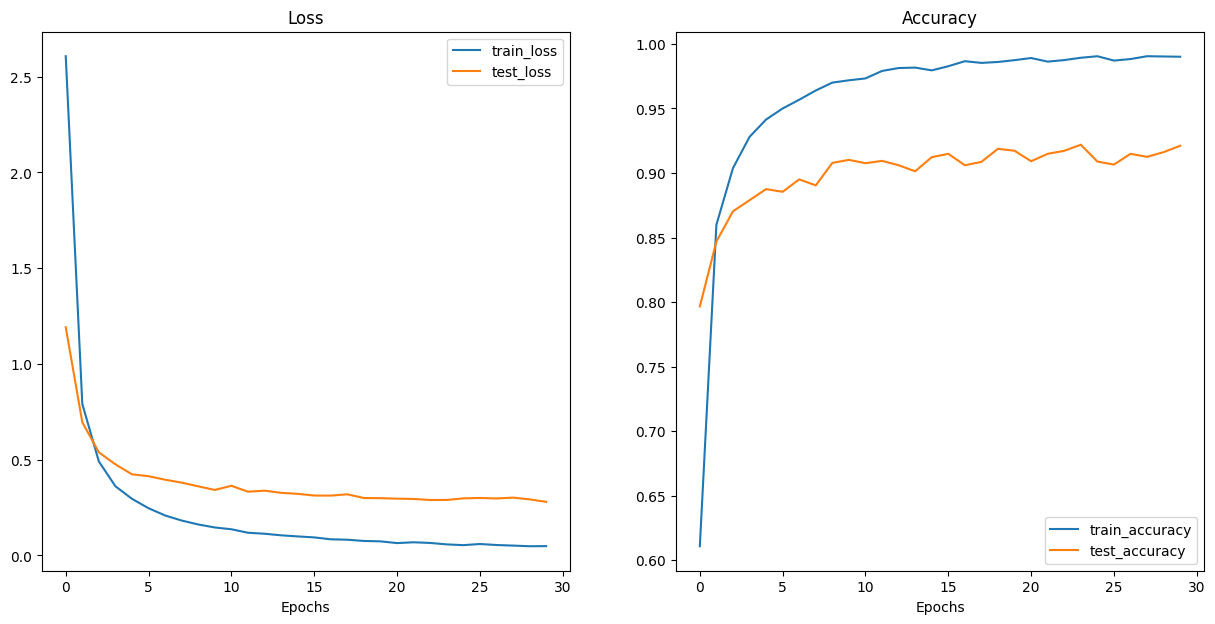

In [15]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

## Define a function to save the model

In [16]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

## Save the model

In [17]:
save_model(model=model,
           target_dir="models",
           model_name="animalclassification.pth")

[INFO] Saving model to: models\animalclassification.pth


## Define a function to load the model

In [6]:
def load_model(target_dir: str,
               model_name: str):
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_path = target_dir + "/" + model_name  
  return torch.load(model_path)

## Load the model

In [7]:
model = torchvision.models.efficientnet_v2_s()

output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

model.load_state_dict(load_model(target_dir="models",
                                 model_name="animalclassification.pth"))
model.to(device);

## Evaluate and plot image function

In [18]:
from typing import List, Tuple
import matplotlib.pyplot as plt
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        translation: dict[str, str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} ({translation[class_names[target_image_pred_label]]}) | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

## Load translation json

In [19]:
import json

with open("./animals141/translation.json", 'r') as file:
    translation = json.load(file)

## Choose random images from test

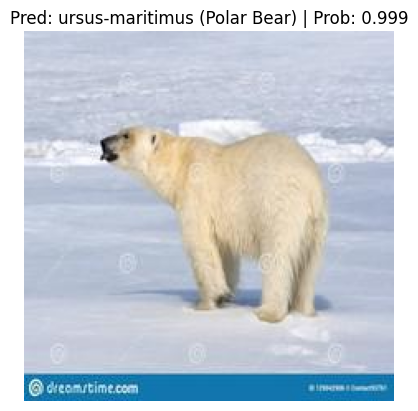

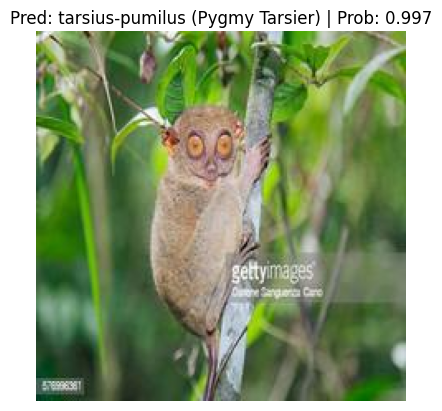

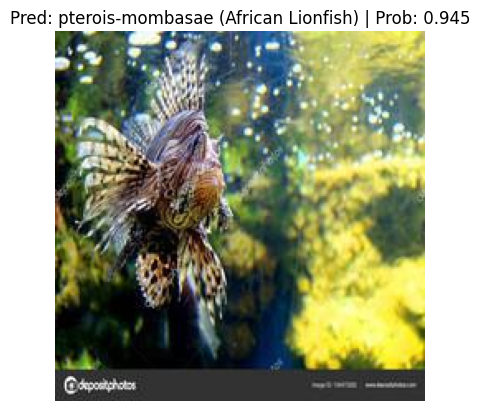

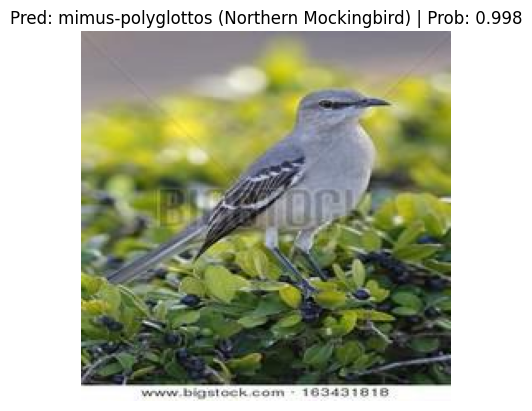

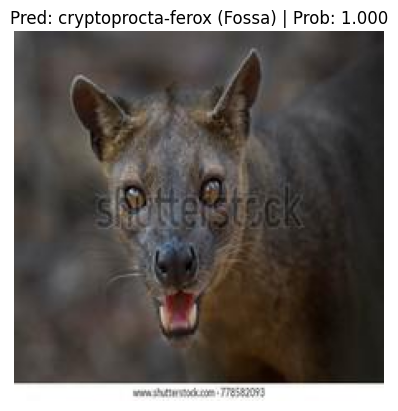

In [20]:
import random
num_images_to_plot = 5
test_image_path_sample = random.sample(population=test_dataset.dataset.imgs, 
                                       k=num_images_to_plot) 

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path[0],
                        class_names=class_names,
                        translation=translation,
                        image_size=(image_size, image_size))

## Test specific image

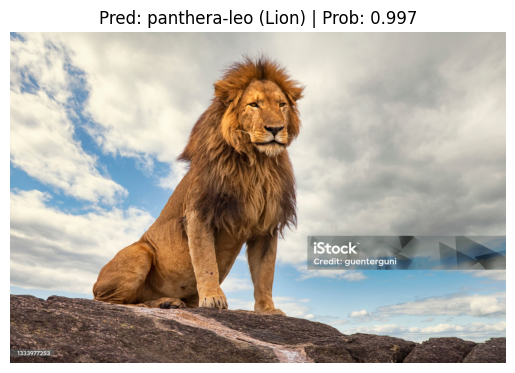

In [21]:
import requests
from pathlib import Path

data_path = Path("./")
custom_image_path = data_path / "lion.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://media.istockphoto.com/id/1333977253/pt/foto/male-lion-resting-on-a-rock.jpg?s=2048x2048&w=is&k=20&c=fDjA8U2REiLWFUFCTY7-y4UNABDXhBfCB778gVrPjAo=")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model, 
                    image_path=custom_image_path,
                    class_names=class_names,
                    translation=translation,
                    image_size=(image_size, image_size))

## Test all dataset

In [22]:
all_dataloader = DataLoader(all_dataset, batch_size=1)

y_pred = []
y_true = []

model.to(device)
model.eval()
for batch, (X, y) in enumerate(all_dataloader):
    with torch.inference_mode():
        target_image_pred = model(X.to(device))
    y_pred_class = torch.argmax(torch.softmax(target_image_pred, dim=1), dim=1)
    y_pred.append(int(y_pred_class.cpu()))        
    y_true.append(int(y))     

## Show confusion_matrix

In [23]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,

## Show precision score

In [24]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='micro'), precision_score(y_true, y_pred, average='macro'), precision_score(y_true, y_pred, average='weighted')

(0.9824561403508771, 0.9822101721599402, 0.9829528898773683)

## Show recall score

In [25]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='micro'), recall_score(y_true, y_pred, average='macro'), recall_score(y_true, y_pred, average='weighted')

(0.9824561403508771, 0.9812052381295543, 0.9824561403508771)

## Show f1 score

In [26]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='micro'), f1_score(y_true, y_pred, average='macro'), f1_score(y_true, y_pred, average='weighted')

(0.9824561403508771, 0.9813835896757577, 0.9824270160035746)